#### Install the library [**foolbox**](https://foolbox.jonasrauber.de/) for adversarial attacks

In [1]:
%pip install -q foolbox

Note: you may need to restart the kernel to use updated packages.


#### Loading library

In [2]:
%matplotlib inline

import foolbox as fb
import tensorflow as tf
from tensorflow.keras import models, Model

import numpy as np
import matplotlib.pyplot as plt

from json import load
import os, re, logging

print("Tensorflow version:" + tf.__version__)

Tensorflow version:2.7.0


#### Global config

In [3]:
# data path
DATA_PATH = "data"
ORIGIN_DATA_PATH = os.path.join(DATA_PATH, "origin")
ADVERSARY_DATA_PATH = os.path.join(DATA_PATH, "adversary")
# load defined label
LABEL_TAGS = load(open(os.path.join(DATA_PATH, "class_dict_10.json"), 'r'))
# save the adversarial image
SAVE_ADVERSARIAL_IMAGE = True

#### Define some useful function

In [4]:
def decode_img(img: tf.Tensor, img_size: tuple=(64, 64)):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, img_size)

def encode_img(img: tf.Tensor, img_size: tuple=(64, 64)):
  img = tf.image.resize(img, img_size)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  return tf.image.encode_jpeg(img)

def get_label(file: str) -> int:
    image_name = os.path.basename(file)
    label_name = re.sub(r'(.+)_\d+\.jpeg', r'\1', image_name)
    for k, v in LABEL_TAGS.items():
        if label_name in v['class']:
            return v['index']
    logging.error("Could not find the label for the file: {}" % file)

def process_path(file_path: str) -> tuple:
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [5]:
def get_FModel(model: Model, bounds: tuple=(0, 1), preprocessing: dict=dict()):
    fmodel = fb.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)
    fmodel = fmodel.transform_bounds((0, 1))
    return fmodel

def show_result(model: Model, origin: list, adversary: list, label: list):
    plt.figure(figsize=(15, 9))
    plt.subplot(131)
    plt.title("origin label %d" % label[0])
    plt.axis("off")
    plt.imshow(origin[0])
    plt.subplot(132)
    plt.title("adversary predict label %d" % np.argmax(model.predict(adversary)))
    plt.axis("off")
    plt.imshow(adversary[0])
    plt.subplot(133)
    plt.title("difference")
    plt.axis("off")
    plt.imshow(adversary[0] - origin[0] + 0.5)
    plt.show()

#### Load dataset

In [6]:
filenames = tf.io.gfile.glob(os.path.join(ORIGIN_DATA_PATH, "*"))
origin_dataset = [process_path(i) for i in filenames]

#### Load model

In [7]:
model = models.load_model("model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1_1 (Conv2D)           (None, 62, 62, 10)        280       
                                                                 
 relu_1_1 (Activation)       (None, 62, 62, 10)        0         
                                                                 
 conv_1_2 (Conv2D)           (None, 60, 60, 10)        910       
                                                                 
 relu_1_2 (Activation)       (None, 60, 60, 10)        0         
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 30, 30, 10)        0         
                                                                 
 conv_2_1 (Conv2D)           (None, 28, 28, 10)        910       
                                                                 
 relu_2_1 (Activation)       (None, 28, 28, 10)        0

#### Attack begin
Try to find the **mini** epsilon

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
The best epsilon: 0.007263


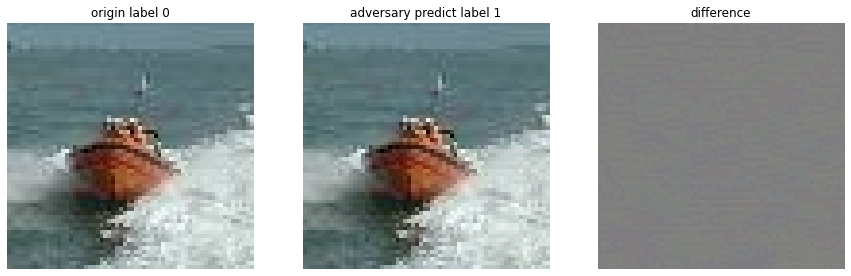

The best epsilon: 0.027007


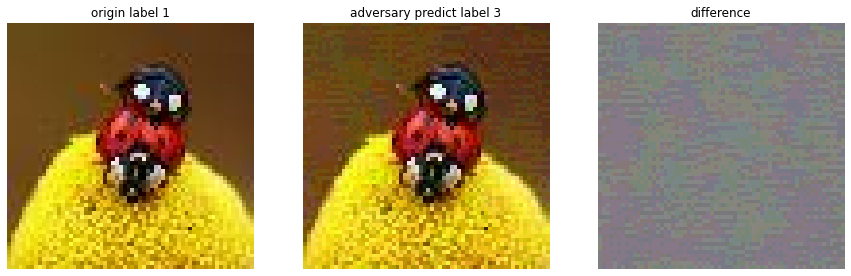

The best epsilon: 0.001953


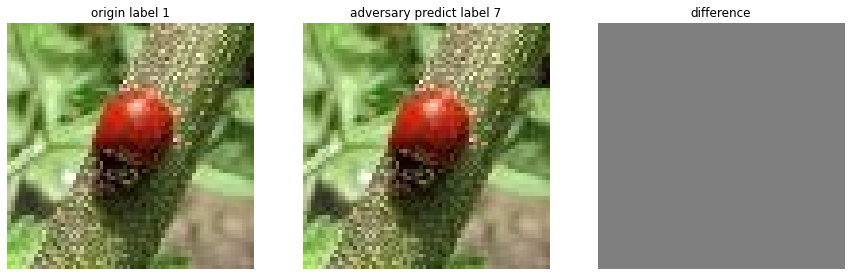

The best epsilon: 0.001953


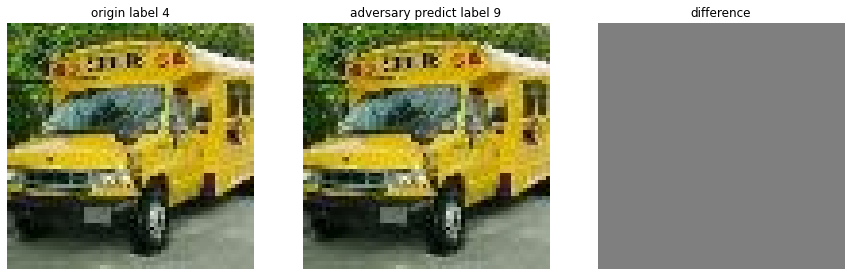

The best epsilon: 0.010085


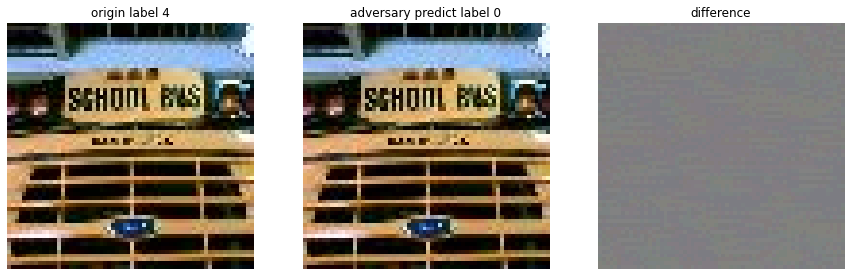

The best epsilon: 0.037503


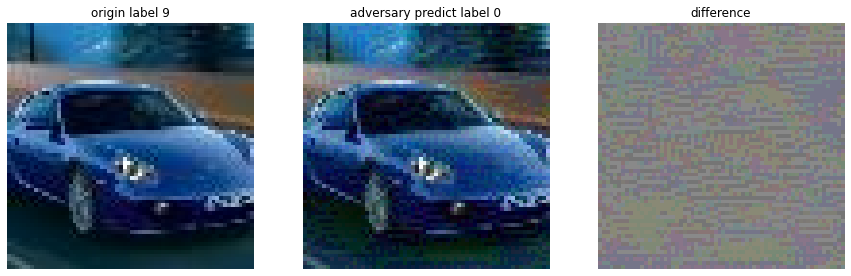

The best epsilon: 0.003766


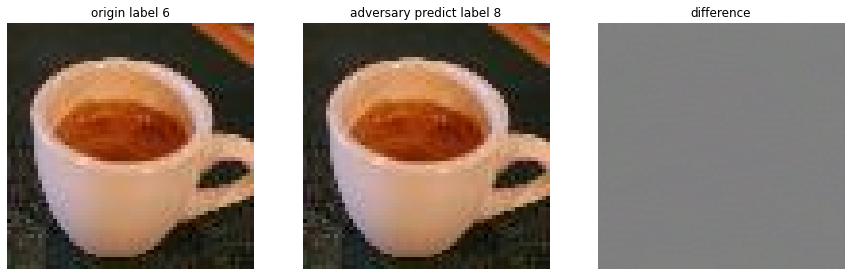

The best epsilon: 0.010085


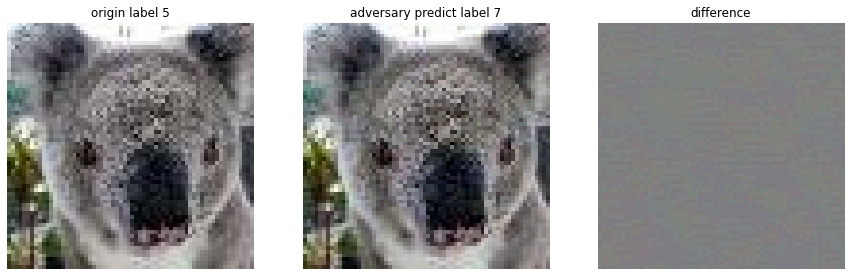

The best epsilon: 0.001953


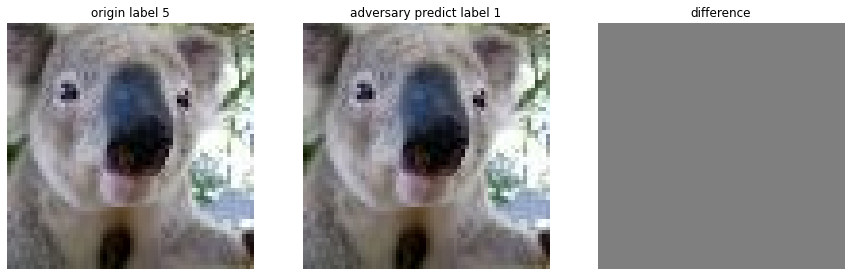

The best epsilon: 0.019448


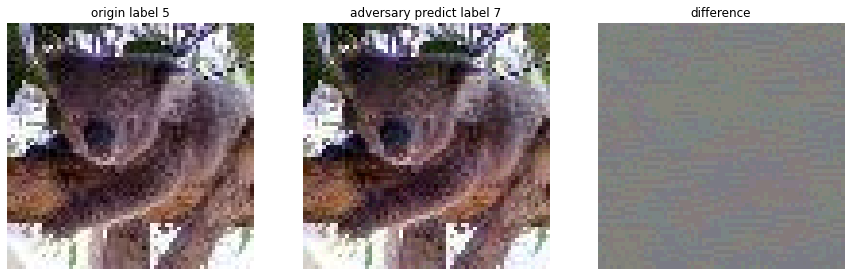

The best epsilon: 0.002712


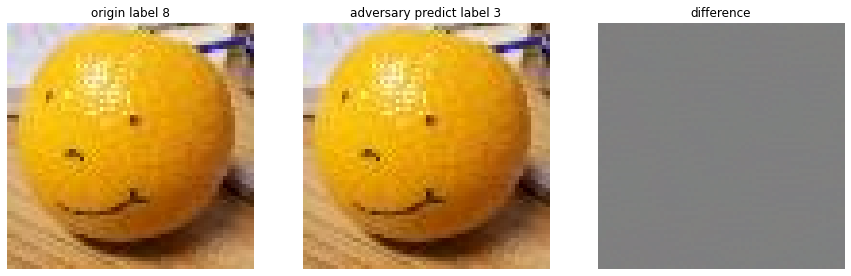

The best epsilon: 0.007263


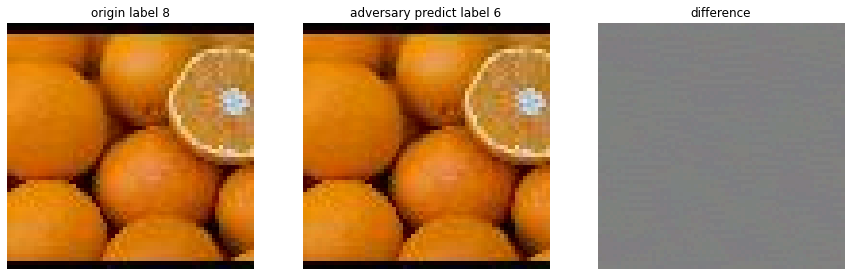

The best epsilon: 0.010085


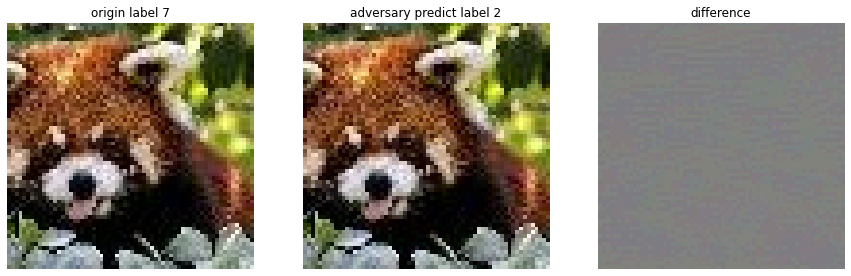

The best epsilon: 0.001953


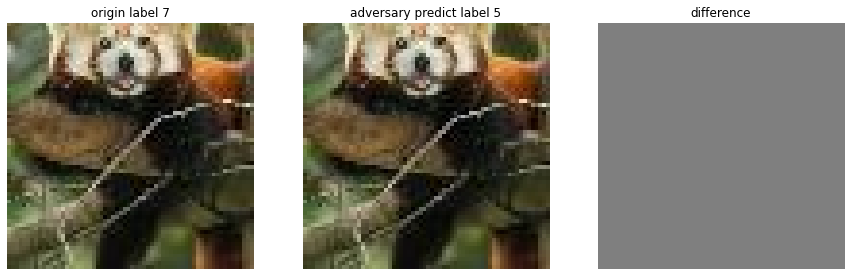

The best epsilon: 0.001953


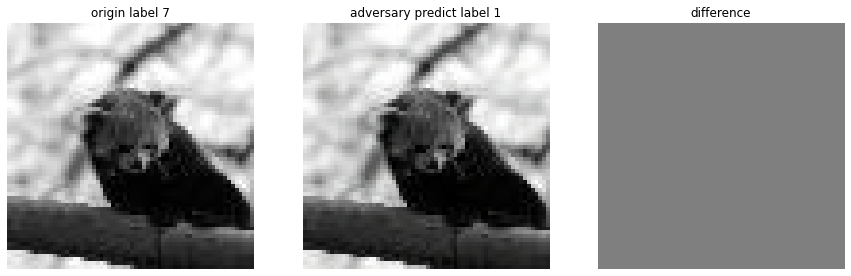

The best epsilon: 0.001953


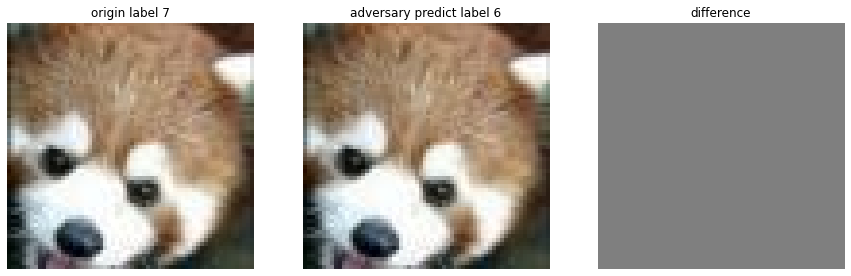

The best epsilon: 0.037503


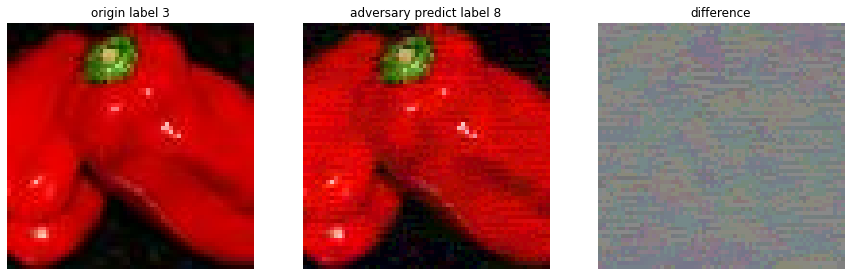

The best epsilon: 0.010085


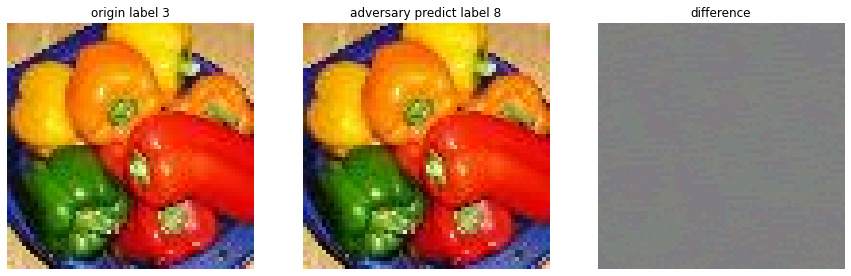

The best epsilon: 0.019448


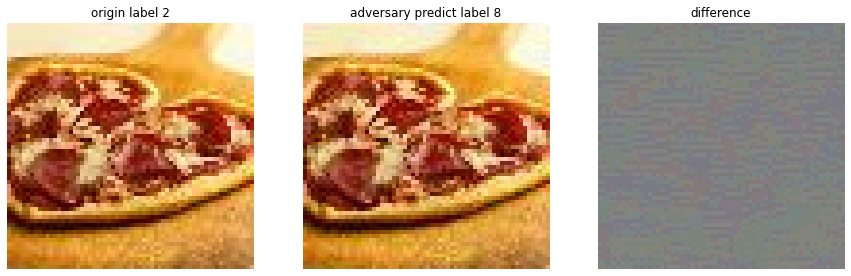

The best epsilon: 0.005230


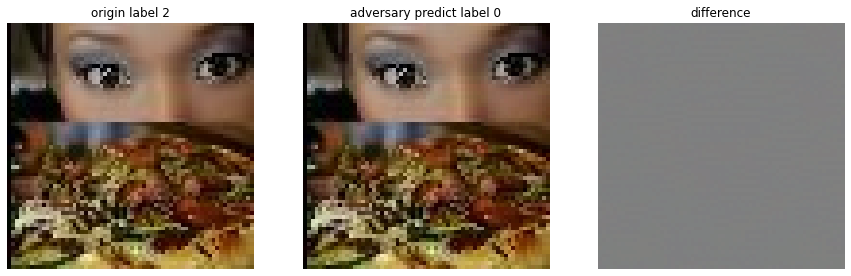

In [8]:
epsilons = np.logspace(-9, 0, num=20, base=2)

fmodel = get_FModel(model)
attack = fb.attacks.FGSM()

for index in range(len(origin_dataset)):
    images = tf.expand_dims(origin_dataset[index][0], axis=0)
    labels = tf.constant(origin_dataset[index][1], shape=(1, ))
    raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)
    # try to find the mini epsilon
    best_index = len(is_adv) - 1
    for i in range(len(is_adv)):
        if is_adv[i].numpy():
            best_index = i
            break
    print("The best epsilon: %f" % epsilons[best_index])
    show_result(model, images, clipped[best_index], labels)
    if SAVE_ADVERSARIAL_IMAGE:
        tf.io.write_file(
            os.path.join(ADVERSARY_DATA_PATH, os.path.basename(filenames[index])),
            encode_img(clipped[best_index][0]))